In [1]:
%load_ext autoreload
%autoreload 2

from datetime import date

import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from volatility_trading.config.constants import CALENDAR_DAYS_PER_YEAR
from volatility_trading.data.orats_io import (
    load_orats_panel_lazy, orats_wide_to_long
)

In [27]:
start = pl.date(2007, 1, 1)
end = pl.date(2025, 12, 31)

cols = [
    "ticker",
    "trade_date",
    "expiry_date",
    "dte",
    "yte",
    "strike",
    "underlying_price",
    "spot_price",
    "smoothed_iv",
    "call_volume", "put_volume",
    "call_open_interest", "put_open_interest",
    "call_bid_price", "put_bid_price",
    "call_mid_price", "put_mid_price",
    "call_ask_price", "put_ask_price",
    "call_delta", "put_delta",
    "call_gamma", "put_gamma",
    "call_theta", "put_theta",
    "call_vega", "put_vega",
    "call_rho", "put_rho",
    "risk_free_rate", "dividend_yield",
]

lf = load_orats_panel_lazy("SPX", columns=cols)
lf = lf.filter(
    pl.col("trade_date").is_between(start, end),
    pl.col("call_delta").abs().is_between(0.01, 0.99),
    pl.col("put_delta").abs().is_between(0.01, 0.99),
)

df = lf.collect()
df.head()

ticker,trade_date,expiry_date,dte,yte,strike,underlying_price,spot_price,smoothed_iv,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,put_bid_price,call_mid_price,put_mid_price,call_ask_price,put_ask_price,call_delta,put_delta,call_gamma,put_gamma,call_theta,put_theta,call_vega,put_vega,call_rho,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1330.0,1414.8,1397.68,0.130463,0,44,96,20055,87.6,0.45,88.6,0.7,89.6,0.95,0.989844,-0.010156,0.000679,0.000679,-0.2505,-0.426464,0.093225,0.093225,0.611189,-0.006929,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1335.0,1414.8,1397.68,0.13003,0,871,124,29467,82.7,0.55,83.7,0.775,84.7,1.0,0.985808,-0.014192,0.00091,0.00091,-0.260895,-0.437521,0.117067,0.117067,0.610823,-0.00962,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1340.0,1414.8,1397.68,0.129422,0,2607,446,62449,77.8,0.65,78.8,0.9,79.8,1.15,0.980553,-0.019447,0.001197,0.001197,-0.273249,-0.450537,0.144801,0.144801,0.609643,-0.013123,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1345.0,1414.8,1397.68,0.128842,0,1591,60,23460,72.9,0.75,73.9,1.0,74.9,1.25,0.973872,-0.026128,0.001544,0.001544,-0.287797,-0.465746,0.177971,0.177971,0.60751,-0.01758,0.0484,0.0
"""SPX""",2007-01-03,2007-01-20,17,0.04658,1350.0,1414.8,1397.68,0.128218,5776,2245,10320,101031,68.1,1.0,69.1,1.1,70.1,1.2,0.96533,-0.03467,0.001964,0.001964,-0.304815,-0.483426,0.2158289,0.2158289,0.604134,-0.02328,0.0484,0.0


In [10]:
df.describe()

statistic,ticker,trade_date,expiry_date,dte,yte,strike,underlying_price,spot_price,smoothed_iv,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,put_bid_price,call_mid_price,put_mid_price,call_ask_price,put_ask_price,call_delta,put_delta,call_gamma,put_gamma,call_theta,put_theta,call_vega,put_vega,call_rho,put_rho,risk_free_rate,dividend_yield
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""8278626""","""8278626""","""8278626""",8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6,8.278626e6
"""null_count""","""0""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,"""2020-12-02 21:52:03.442658""","""2021-01-11 07:52:16.650067""",39.41682,0.107992,3731.658019,3884.851301,3874.187944,0.208599,105.450198,163.383251,1104.062479,1614.16795,235.328798,78.46931,237.054856,79.380056,238.780915,80.290802,0.633223,-0.366777,0.001438,0.001438,-0.883768,-1.178535,2.728749,2.728749,2.023852,-1.872143,0.023475,0.0
"""std""",null,null,null,23.004156,0.063025,1461.87565,1473.94919,1463.465216,0.098939,888.880581,1174.431088,6533.358406,8313.705274,267.026293,115.420699,268.373572,116.625534,269.730432,117.839948,0.324899,0.324899,0.001503,0.001503,0.715682,0.863897,2.16205,2.16205,1.716915,2.148312,0.021346,0.0
"""min""","""SPX""","""2007-01-03""","""2007-01-12""",7.0,0.01918,350.0,672.995,667.5,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,-0.99,0.000017,0.000017,-12.96251,-13.534207,0.025404,0.025404,0.001448,-18.942357,0.0,0.0
"""25%""",null,"""2018-09-04""","""2018-10-17""",21.0,0.05753,2550.0,2712.335797,2717.7,0.13524,0.0,0.0,0.0,5.0,34.9,8.5,35.25,8.75,35.7,8.9,0.361527,-0.638473,0.000448,0.000448,-1.240543,-1.740994,1.022589,1.022589,0.714846,-2.522048,0.001,0.0
"""50%""",null,"""2021-10-27""","""2021-12-03""",35.0,0.09589,3765.0,3956.79,3942.2,0.189536,0.0,3.0,16.0,64.0,148.2,32.0,149.55,32.35,150.9,32.7,0.753189,-0.246811,0.001,0.001,-0.735357,-1.02066,2.203427,2.203427,1.578052,-1.118084,0.0195,0.0
"""75%""",null,"""2024-01-24""","""2024-02-29""",57.0,0.15616,4755.0,4852.25,4828.58,0.258559,10.0,25.0,171.0,364.0,336.9,99.3,339.75,100.35,342.6,101.4,0.919242,-0.080758,0.001883,0.001883,-0.341775,-0.456682,3.850525,3.850525,2.875435,-0.398478,0.0438,0.0
"""max""","""SPX""","""2025-12-05""","""2026-02-27""",90.0,0.24658,8000.0,6956.33,6899.64,1.52649,140444.0,148838.0,380865.0,417654.0,2533.7,1394.5,2541.9,1403.4,2550.1,1412.3,0.99,-0.01,0.041888,0.041888,-0.003131,-0.003665,13.481006,13.481006,10.24198,0.010222,0.0602,0.0


## Days-to-expiry check 

Over the years we should see min and max dte for each day becomeign closer toà 7 and 60 DTE while a global  min and max DTE of 7 and 60 

In [ ]:
dte_yte_check = (
    df
    .group_by(["trade_date"])
    .agg(
        pl.col("dte").min().alias("dte_min"),
        pl.col("dte").max().alias("dte_max"),
        (pl.col("dte") - pl.col("yte") * CALENDAR_DAYS_PER_YEAR)
        .abs()
        .mean()
        .alias("mean_abs_diff"),
    )
    .sort("trade_date")
)

dte_min_global = df.select(pl.col("dte").min()).item()
dte_max_global = df.select(pl.col("dte").max()).item()

print(f"Global DTE range: [{dte_min_global}, {dte_max_global}]")
dte_yte_check

Global DTE range: [7, 90]


trade_date,dte_min,dte_max,mean_abs_diff
date,i64,i64,f64
2007-01-03,17,73,0.000673
2007-01-04,16,72,0.000655
2007-01-05,7,71,0.000655
2007-01-08,12,68,0.000565
2007-01-09,11,67,0.000567
…,…,…,…
2025-12-01,7,88,0.001094
2025-12-02,7,87,0.001065
2025-12-03,7,86,0.001037


## Spot Price S check

Here we should expect only 1 spot price for each date.

In [46]:
spot_check = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("spot_price").n_unique().alias("n_spot_values"),
        pl.col("spot_price").min().alias("spot_min"),
        pl.col("spot_price").max().alias("spot_max"),
    )
    .sort("trade_date")
)

spot_issues = spot_check.filter(pl.col("n_spot_values") > 1)
print("Number of issues:", spot_issues.height)
spot_check

Number of issues: 0


trade_date,n_spot_values,spot_min,spot_max
date,u32,f64,f64
2007-01-03,1,1397.68,1397.68
2007-01-04,1,1400.48,1400.48
2007-01-05,1,1389.35,1389.35
2007-01-08,1,1396.15,1396.15
2007-01-09,1,1394.39,1394.39
…,…,…,…
2025-12-01,1,6823.63,6823.63
2025-12-02,1,6834.96,6834.96
2025-12-03,1,6859.93,6859.93


## Parity implied forward price F check

Should expected as many implied prices than expiries listed for eahc day.

In [ ]:
underlying_checks = (
    df
    .group_by("trade_date")
    .agg(
        pl.col("underlying_price").n_unique().alias("n_spot_values"),
        pl.col("expiry_date").n_unique().alias("n_expiries"),
        pl.col("underlying_price").min().alias("spot_min"),
        pl.col("underlying_price").max().alias("spot_max"),
    )
    .sort("trade_date")
)

underlying_checks

trade_date,n_spot_values,n_expiries,spot_min,spot_max
date,u32,u32,f64,f64
2007-01-03,3,3,1411.1,1414.8
2007-01-04,3,3,1414.05,1418.16
2007-01-05,4,4,1403.0,1407.48
2007-01-08,3,3,1409.58,1413.65
2007-01-09,3,3,1407.73,1411.6
…,…,…,…,…
2025-12-01,31,28,6824.58,6880.25
2025-12-02,30,28,6841.77,6896.65
2025-12-03,31,28,6862.6,6916.67


## Risk free rate check

In [51]:
rate_check = (
    df
    .group_by(["trade_date"])
    .agg(
        pl.col("risk_free_rate").n_unique().alias("n_rf"),
        pl.col("risk_free_rate").min().alias("rf_min"),
        pl.col("risk_free_rate").max().alias("rf_max"),
    )
    .sort(["trade_date"])
)

rate_issues = rate_check.filter(pl.col("n_rf") > 1)
rate_issues

trade_date,n_rf,rf_min,rf_max
date,u32,f64,f64
2007-01-03,2,0.0484,0.0505
2007-01-04,2,0.048,0.0504
2007-01-05,2,0.0481,0.0505
2007-01-08,2,0.0487,0.0508
2007-01-09,2,0.049,0.0508
…,…,…,…
2025-12-01,2,0.0392,0.0406
2025-12-02,2,0.0381,0.0398
2025-12-03,2,0.0377,0.039


# **Smoothed Implied Volatility Checks**

In [7]:
iv_stats = df.select(pl.col("smoothed_iv")).describe()
iv_stats

statistic,smoothed_iv
str,f64
"""count""",8.278626e6
"""null_count""",0.0
"""mean""",0.208599
"""std""",0.098939
"""min""",0.01
"""25%""",0.13524
"""50%""",0.189536
"""75%""",0.258559
"""max""",1.52649


In [6]:
df.select(
    (pl.col("smoothed_iv") < 0).sum().alias("n_negative"),
    (pl.col("smoothed_iv") > 3.0).sum().alias("n_above_300pct"),
    pl.len().alias("n_total"),
)

n_negative,n_above_300pct,n_total
u32,u32,u32
0,0,8278626


## **Smile shape using *smoothed_iv* for 10, 30 and 60 DTE**

**What we’re looking for**

- Smiles are **smooth** functions of strike (no crazy spikes for single strikes).
- Shorter maturities show more curvature / higher IV during stressed periods.
- Shapes are consistent with equity index behaviour:
  - Higher IV for low deltas (OTM puts),
  - Lower IV for high deltas (OTM calls), i.e. a negative skew.
- No obvious arbitrage-like patterns:
  - IV not wildly non-monotone in wings,
  - Different maturities do not cross each other in pathological ways.

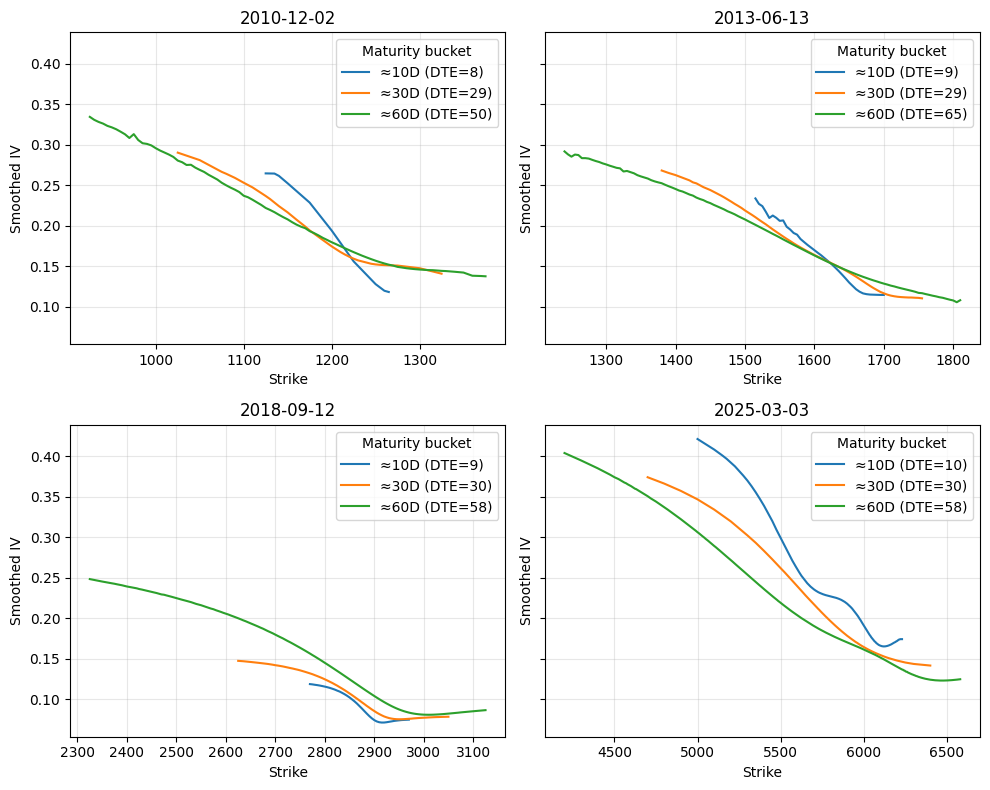

In [ ]:
def pick_closest_dte(dtes: list[int], target: int, max_tol: int = 5):
    """
    Return the DTE closest to `target` within `max_tol` days, else None.
    """
    if not dtes:
        return None
    best = min(dtes, key=lambda d: abs(d - target))
    return best if abs(best - target) <= max_tol else None


targets = [
    (10, "≈10D"),
    (30, "≈30D"),
    (60, "≈60D"),
]

picked_dates = [
    date(2010, 12, 2),
    date(2013, 6, 13),
    date(2018, 9, 12),
    date(2025, 3, 3),
]


nrows, ncols = 2, 2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(5 * ncols, 4 * nrows),
    sharex=False,
    sharey=True,
)
axes = axes.ravel()

for ax, day in zip(axes, picked_dates):
    sub = df.filter(pl.col("trade_date") == day)
    if sub.height == 0:
        ax.set_axis_off()
        continue

    dtes = (sub.select(pl.col("dte").unique()).sort("dte").to_series().to_list())

    chosen = {}
    for target, label in targets:
        best = pick_closest_dte(dtes, target, max_tol=10)
        if best is not None:
            chosen[label] = best

    if not chosen:
        ax.set_axis_off()
        continue

    for label, dte_val in chosen.items():
        grp = (
            sub
            .filter(pl.col("dte") == dte_val)
            .sort("strike")
        )
        if grp.height == 0:
            continue

        ax.plot(
            grp["strike"].to_numpy(),
            grp["smoothed_iv"].to_numpy(),
            label=f"{label} (DTE={dte_val})",
            linewidth=1.5,
        )
    ax.set_xlabel("Strike")
    ax.set_ylabel("Smoothed IV")
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.grid(True, alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="upper right", title="Maturity bucket")

for k in range(len(picked_dates), len(axes)):
    axes[k].set_axis_off()

fig.tight_layout()
plt.show()

# **Greeks Sanity Checks**

In [60]:
checks = df.select(
    # Deltas
    (pl.col("call_delta") <= 0).sum().alias("bad_call_delta_le_0"),
    (pl.col("call_delta") >= 1).sum().alias("bad_call_delta_ge_1"),
    (pl.col("put_delta") >= 0).sum().alias("bad_put_delta_ge_0"),
    (pl.col("put_delta") <= -1).sum().alias("bad_put_delta_le_minus1"),

    # Gamma & Vega
    (pl.col("call_gamma") < 0).sum().alias("neg_call_gamma"),
    (pl.col("put_gamma") < 0).sum().alias("neg_put_gamma"),
    (pl.col("call_vega") < 0).sum().alias("neg_call_vega"),
    (pl.col("put_vega") < 0).sum().alias("neg_put_vega"),

    # Rho sign
    (pl.col("call_rho") < 0).sum().alias("call_rho_negative"),
    (pl.col("put_rho") > 0).sum().alias("put_rho_positive"),

    # Theta sign (more relaxed: count how many are positive)
    (pl.col("call_theta") > 0).sum().alias("call_theta_positive"),
    (pl.col("put_theta") > 0).sum().alias("put_theta_positive"),
)

checks

bad_call_delta_le_0,bad_call_delta_ge_1,bad_put_delta_ge_0,bad_put_delta_le_minus1,neg_call_gamma,neg_put_gamma,neg_call_vega,neg_put_vega,call_rho_negative,put_rho_positive,call_theta_positive,put_theta_positive
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,127,0,0


In [65]:
viol = (df
    .filter(pl.col("put_rho") > 0)
    .select("trade_date", "dte", "put_delta", "put_rho")
)
viol

trade_date,dte,put_delta,put_rho
date,i64,f64,f64
2014-10-14,10,-0.010611,0.001512
2014-10-14,10,-0.011363,0.001127
2014-10-14,10,-0.012381,0.000597
2015-09-22,8,-0.010591,0.001195
2015-09-22,8,-0.011611,0.000764
…,…,…,…
2023-11-24,7,-0.014711,0.002554
2023-11-24,7,-0.016367,0.001086
2023-11-24,10,-0.010514,0.001932


Those violations occur only for **deep OTM puts** with **very short expiries**, and their magnitudes are tiny numerical noise.

# **Put–Call Parity checks for put theta & rho**

We start from **European put–call parity** with continuous dividend yield $q$ and
risk-free rate $r$:

$$
C - P = S e^{-qT} - K e^{-rT},
$$

where

- $C, P$ = call and put prices  
- $S$     = spot/underlying price  
- $K$     = strike  
- $T$     = time to expiry in years (our `yte`)  
- $q$     = dividend yield (`dividend_yield`)  
- $r$     = risk-free rate (`risk_free_rate`).

In [48]:
disc_r = (-df["risk_free_rate"] * df["yte"]).exp()
disc_q = (-df["dividend_yield"] * df["yte"]).exp()

## Rho parity

Differentiate parity w.r.t. $r$:

$$
\frac{\partial C}{\partial r} - \frac{\partial P}{\partial r}
  = \frac{\partial}{\partial r} \left(S e^{-qT} - K e^{-rT}\right)
  = 0 - \left(-T K e^{-rT}\right)
  = T K e^{-rT}.
$$

If vendor rhos are defined **per 1% move in rates** (i.e. for $\Delta r = 0.01$),
then

$$
\rho_C = \frac{\partial C}{\partial (0.01 r)}, \quad
\rho_P = \frac{\partial P}{\partial (0.01 r)}
$$

so

$$
\rho_C - \rho_P
  = 0.01 \, T K e^{-rT}.
$$

Re-arranged in the “left minus right hand side ≈ 0” form we actually check:

$$
\rho_P - \rho_C - 0.01 \, T K e^{-rT} \approx 0.
$$

In [ ]:
rhs = df["yte"] * df["strike"] * disc_r / 100
diff = df["call_rho"] - df["put_rho"] - rhs
diff.describe()

statistic,value
str,f64
"""count""",8.278626e6
"""null_count""",0.0
"""mean""",7.79199
"""std""",5.658957
"""min""",0.210976
"""25%""",3.641888
"""50%""",6.13489
"""75%""",10.318387
"""max""",38.213131


## Theta parity

Start from European put–call parity with continuous dividend yield $q$ and
risk-free rate $r$:

$$
C - P = S e^{-qT} - K e^{-rT},
$$

where $T$ is time to expiry in years.

Differentiate parity w.r.t. time to expiry $T$:

$$
\frac{\partial}{\partial T}(C - P)
= \frac{\partial}{\partial T}\left(S e^{-qT} - K e^{-rT}\right)
= -q S e^{-qT} + r K e^{-rT}.
$$

Define **annual** thetas (derivative per unit of $T$ in years):

$$
\Theta_C = \frac{\partial C}{\partial T}, \quad
\Theta_P = \frac{\partial P}{\partial T}.
$$

Then:

$$
\Theta_C - \Theta_P = -q S e^{-qT} + r K e^{-rT}.
$$

If the vendor reports **1-day theta** (`call_theta`, `put_theta`) in
“per calendar day” units, we approximate:

$$
\theta_C \approx \frac{\Theta_C}{365}, \quad
\theta_P \approx \frac{\Theta_P}{365},
$$

so:

$$
\theta_C - \theta_P
\approx \frac{-q S e^{-qT} + r K e^{-rT}}{365}.
$$

Re-arranged in the check form (LHS − RHS $\approx 0$):

$$
\theta_P - \theta_C
- \frac{-q S e^{-qT} + r K e^{-rT}}{365}
\approx 0.
$$

In [54]:
term1 = df["dividend_yield"] * df["underlying_price"] * disc_q
term2 = df["risk_free_rate"] * df["strike"] * disc_r 

rhs = (term2 - term1) / 365
diff = df["call_theta"] - df["put_theta"] - rhs
diff.describe()

statistic,value
str,f64
"""count""",8.278626e6
"""null_count""",0.0
"""mean""",-4.2846e-20
"""std""",7.4062e-17
"""min""",-8.8818e-16
"""25%""",-2.4720e-17
"""50%""",0.0
"""75%""",2.4286e-17
"""max""",8.8818e-16
